In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b>Note:</b> the raw code for this notebook is by default hidden for easier reading.
To toggle the code on/off, click <a href="javascript:code_toggle()">here</a>.''')

# Setup

In [2]:
import torch
import Darwin as dw
import seaborn as sns

from torchvision import datasets, transforms
from bogus import atk
from ipywidgets  import interactive, fixed
from bokeh.io import output_notebook

output_notebook()
sns.set()

Loading BokehJS ...

In [3]:
with open(r"D:\TELEGRAM_BOTS\NEURALUPDATES.txt") as file: #Credentials for telegram bot
    telegram_credentials = file.read().split('\n')

In [4]:
transform = transforms.Compose([
                       transforms.ToTensor()])

MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', 
                            train=True, download=True,
                            transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', 
                            train=False, download=True,
                            transform=transform)

train_loader = torch.utils.data.DataLoader(
                            MNIST_train, batch_size=64, 
                            shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                            batch_size=1000, shuffle=True, 
                            pin_memory=True)

In [5]:
NET_SPACE = {
    'nb_layers': {'lb': 1, 'ub': 3, 'mutate': 0.15},
    'lr': {'lb': 0.001, 'ub':0.1, 'mutate': 0.15},
    'weight_decay': {'lb': 0.00001, 'ub': 0.0004, 'mutate':0.2},
    'optimizer': {'func': ['sgd', 'adam', 'adadelta','rmsprop'], 'mutate': 0.2}
}

In [6]:
LAYER_SPACE = {
    'nb_units':{'lb': 128, 'ub':2048, 'mutate': 0.15},
    'dropout_rate': {'lb': 0.0, 'ub': 0.7, 'mutate': 0.2},
    'activation': {'func': ['linear','tanh','relu','sigmoid','elu'], 'mutate':0.2}
}

In [7]:
atk_func = atk()

# Run 

In [8]:
testing = dw.TournamentOptimizer(8, LAYER_SPACE, NET_SPACE, dw.randomize_network, 
                           dw.mutate_net, dw.NetFromBuildInfo, dw.train, dw.test,
                          train_loader, test_loader, atk_func.fgsm, telegram_credentials)

In [9]:
testing.step(generations=5, epochs=3, save=True, phone=False)

Generation 1 Population mean:217.0 max:974

Top performers:
0: score:974
1: score:710


Generation 2 Population mean:517.125 max:1135

Top performers:
0: score:1135
1: score:1032


Generation 3 Population mean:682.5 max:1165

Top performers:
0: score:1165
1: score:1135


Generation 4 Population mean:425.5 max:1028

Top performers:
0: score:1028
1: score:892


Generation 5 Population mean:769.625 max:1135

Top performers:
0: score:1135
1: score:1028



# Plots

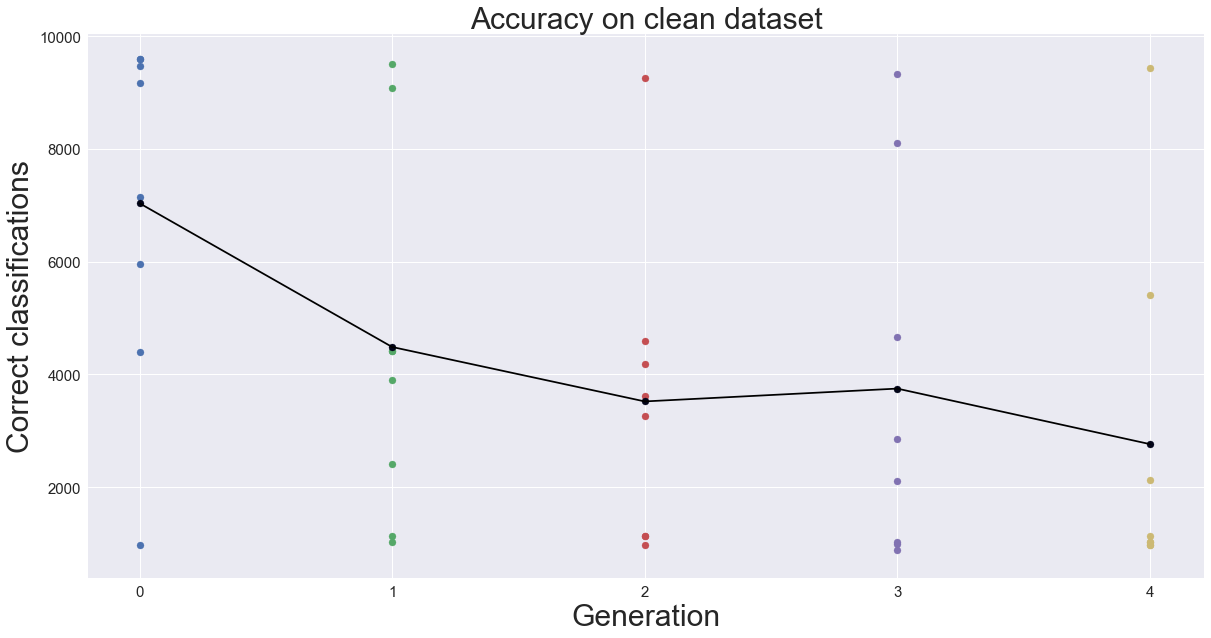

In [10]:
dw.progressplotter(testing, clean=True)

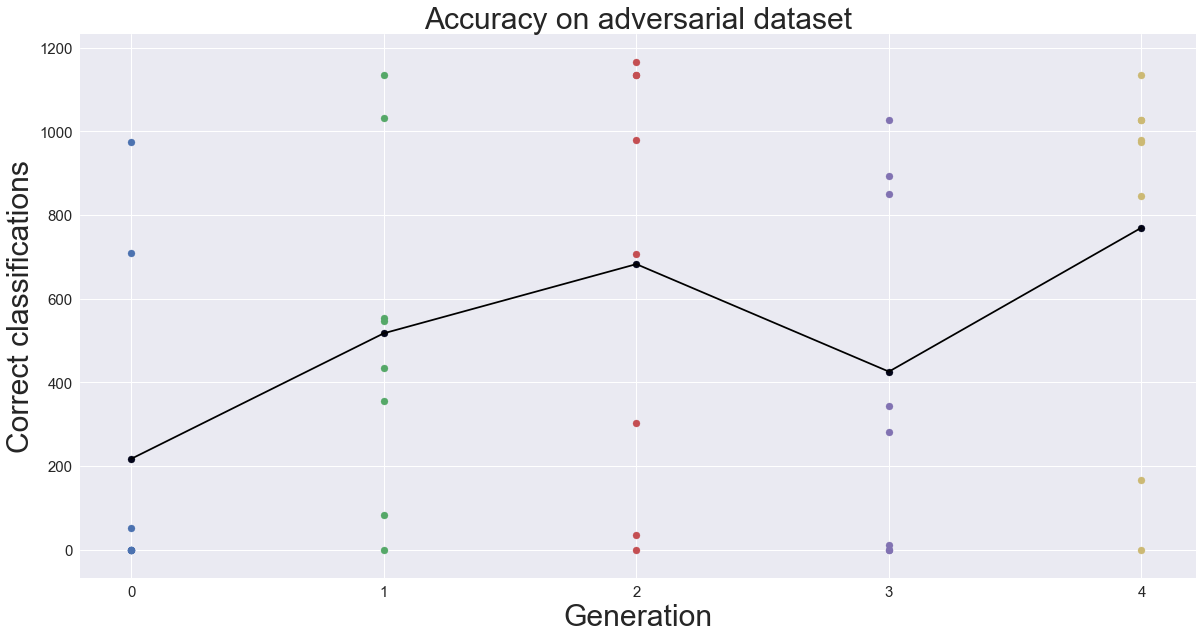

In [11]:
dw.progressplotter(testing)

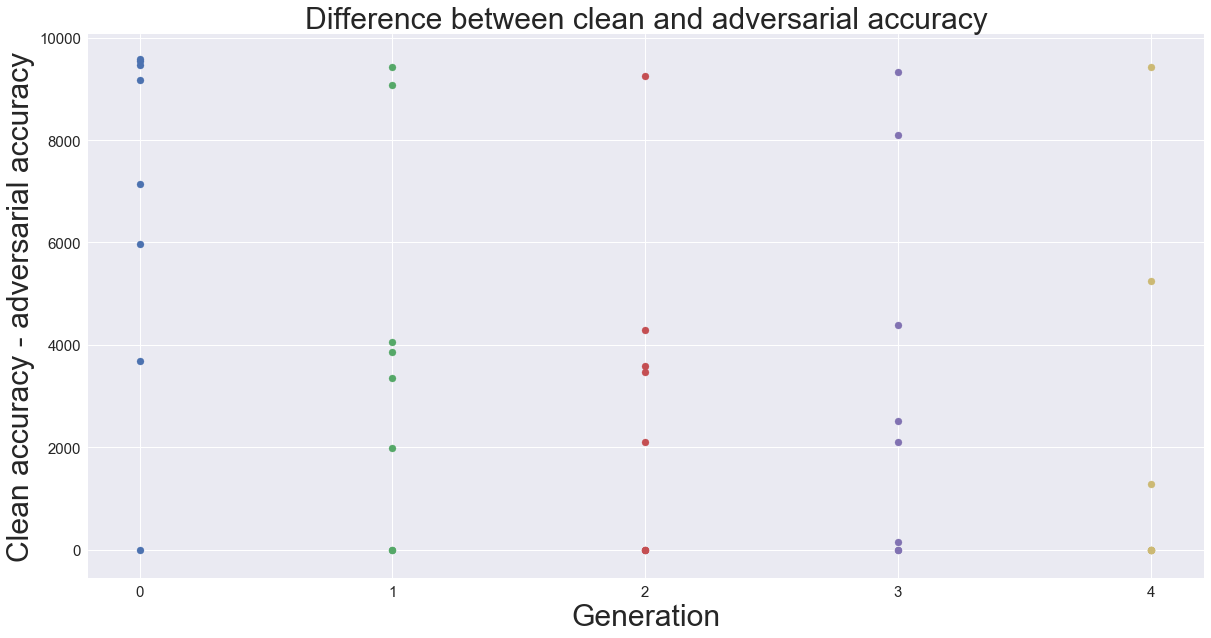

In [12]:
dw.diffplotter(testing)

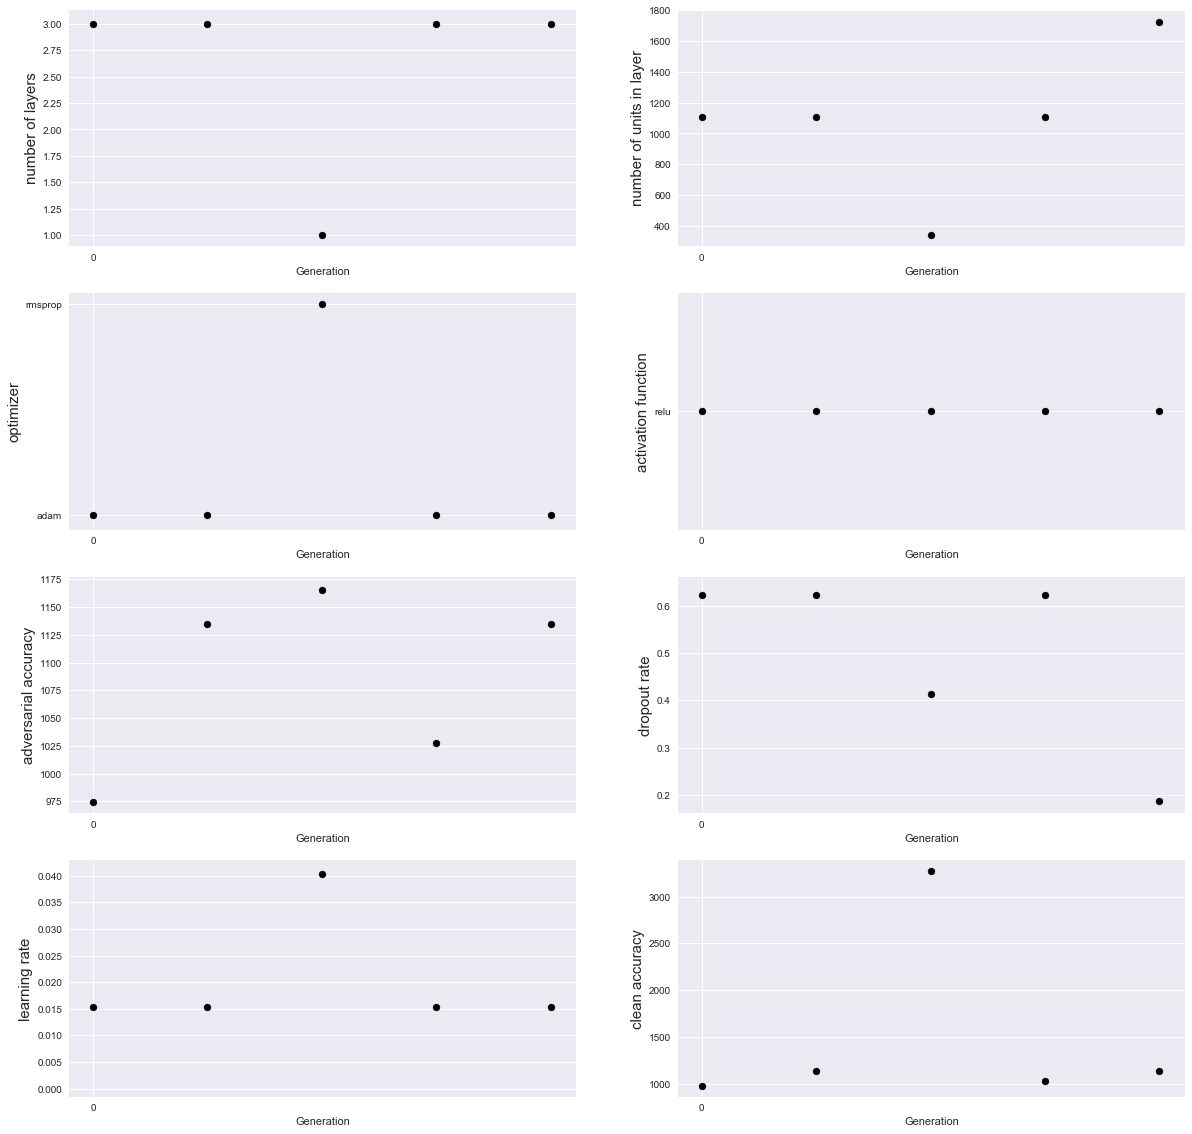

In [13]:
dw.bestplotter(testing, k=0)

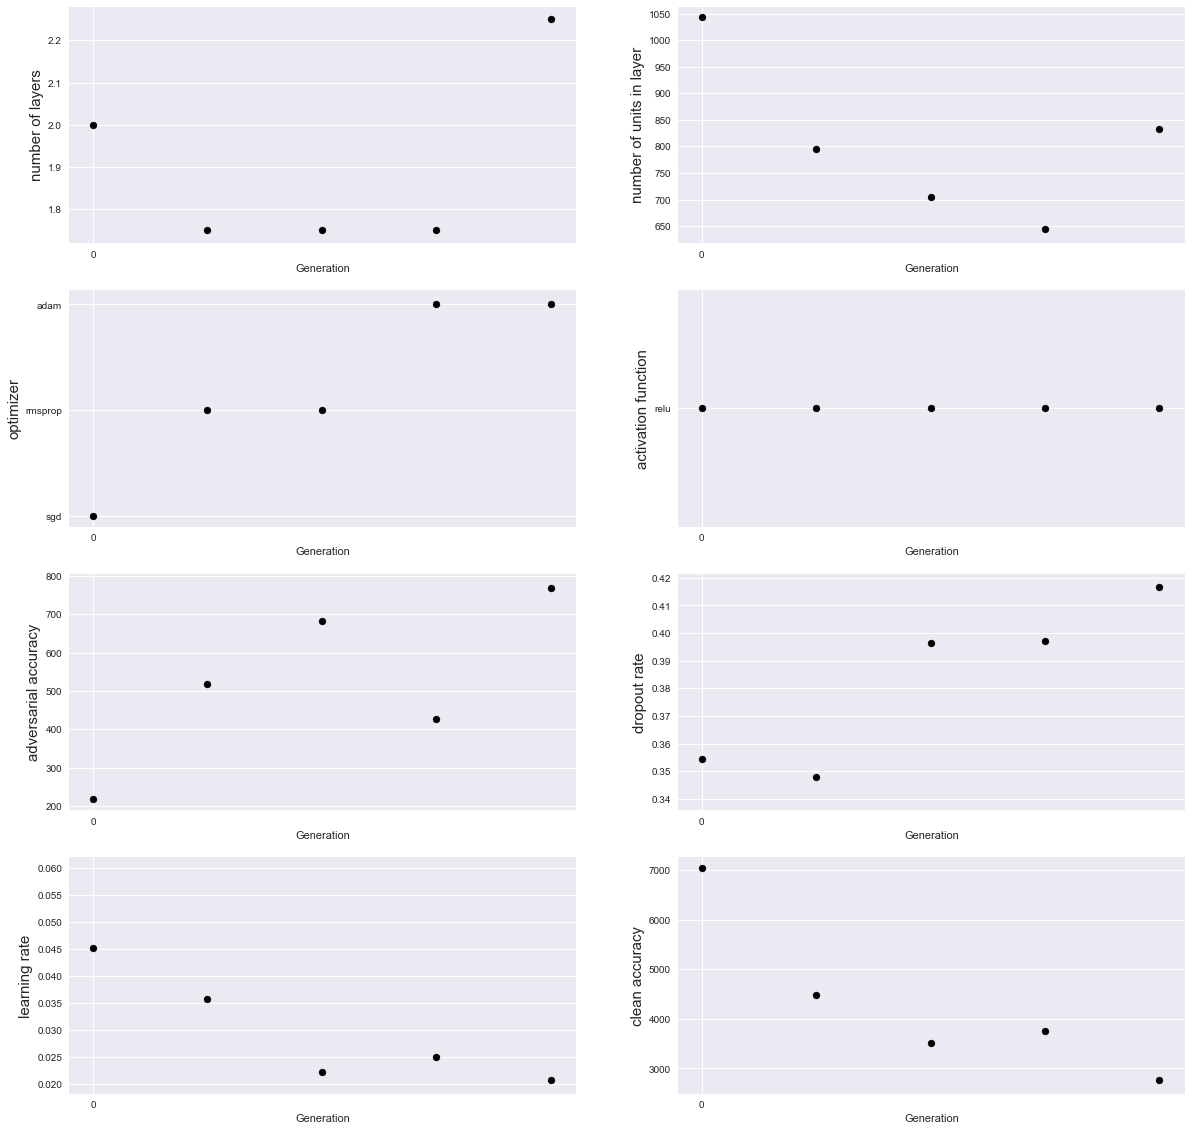

In [14]:
dw.avgplotter(testing)

In [15]:
dw.best_printer(testing)

,adversarial,clean,generation
best_adversarial,1165,3268,3
best_clean,52,9595,1


Showing best model which was found in generation 3
Clean accuracy = 3268
adversarial accuracy =1165

Model: 

 NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=340, bias=True)
    (dropout_0): Dropout(p=0.41421231294029714)
    (relu0): ReLU()
    (logits): Linear(in_features=340, out_features=10, bias=True)
  )
) 

 Images below are adversarial
[[8.93114399e-37 4.50554774e-43 4.50286743e-30 1.01595521e-31
  1.70513560e-39 2.16798971e-29 1.00000000e+00 6.35604557e-30
  1.33267376e-30 5.49034634e-30]]
[[7.86278825e-65 1.00000000e+00 1.63801837e-42 6.34768087e-71
  1.33748359e-45 2.64721791e-41 3.84023116e-24 3.11592253e-42
  6.10956362e-43 3.09270370e-42]]
[[1.82982358e-224 2.28614635e-223 9.12110497e-169 3.31890732e-204
  9.81059676e-167 1.94084397e-168 1.00000000e+000 1.85141315e-168
  4.45376282e-168 6.68764559e-167]]
[[8.50043245e-179 1.00000000e+000 1.56826135e-130 1.96330669e-170
  1.37018507e-143 5.28589739e-129 1.

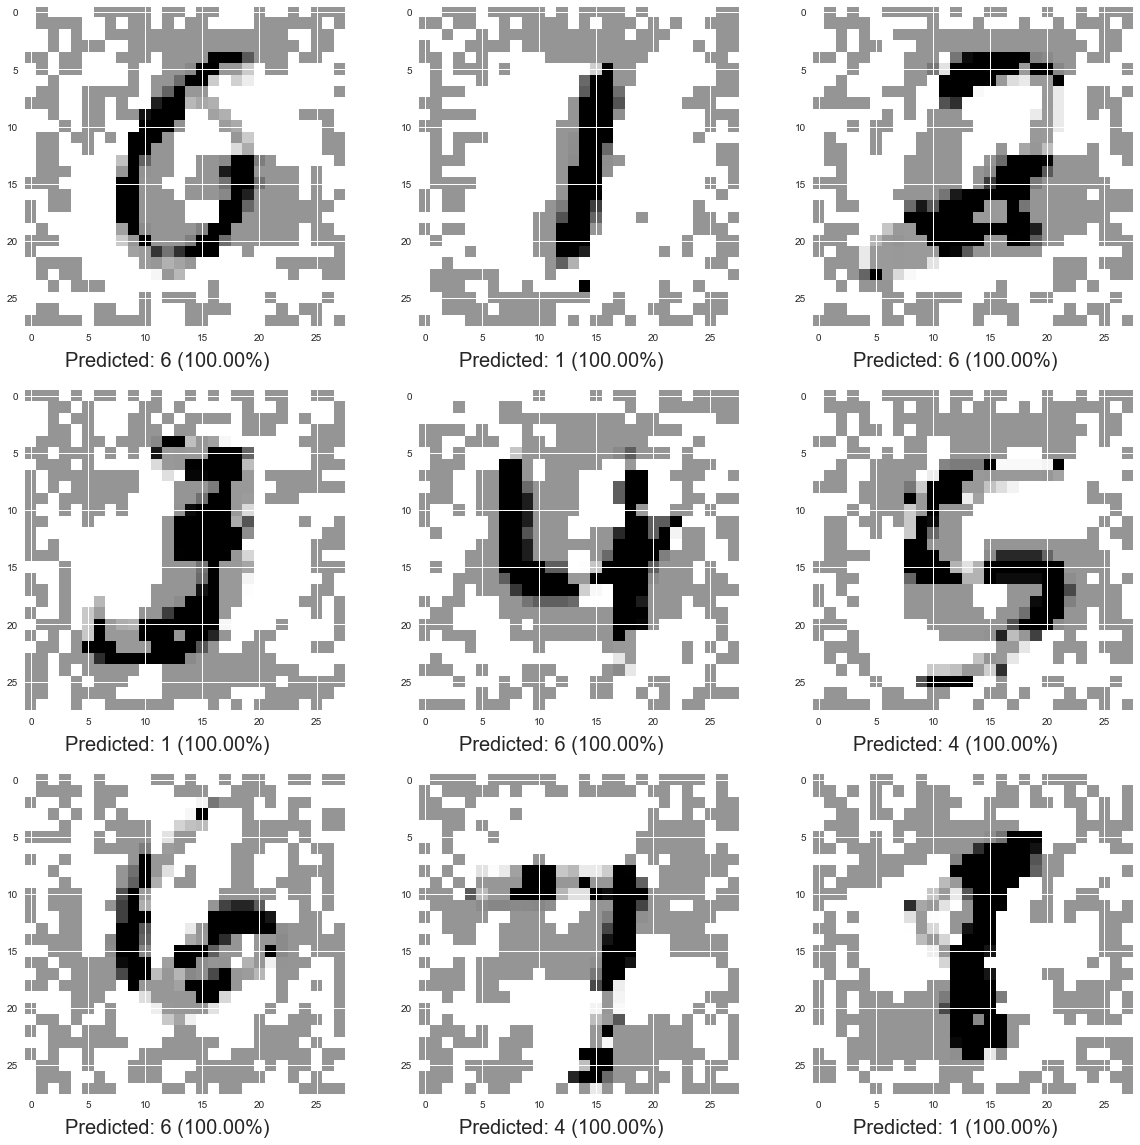

In [16]:
dw.multi_plot(testing, test_loader, adv_func=atk_func.fgsm, adversarial=True, eps=0.5)

Showing best model which was found in generation 3
Clean accuracy = 3268
adversarial accuracy =1165

Model: 

 NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=340, bias=True)
    (dropout_0): Dropout(p=0.41421231294029714)
    (relu0): ReLU()
    (logits): Linear(in_features=340, out_features=10, bias=True)
  )
) 

 Images below are clean
[[1.00000000e+000 1.06761430e-136 6.57923270e-094 5.96074171e-056
  1.62980064e-134 4.73084746e-094 2.11541508e-095 2.13810842e-094
  3.04885676e-095 1.20746292e-094]]
[[3.31483321e-22 1.00000000e+00 8.67352445e-19 5.73454991e-30
  1.42956234e-18 3.92257139e-18 4.45444806e-22 2.57994999e-18
  1.34850179e-18 3.58216581e-18]]
[[3.69266526e-121 3.95154919e-104 5.00263704e-073 9.24215259e-083
  1.00000000e+000 2.08013027e-072 2.73515176e-022 2.81859834e-072
  1.05352173e-072 5.47023658e-072]]
[[3.72034544e-47 1.00000000e+00 1.16632328e-28 5.19521089e-26
  4.21744575e-47 3.77004925e-28 5.00

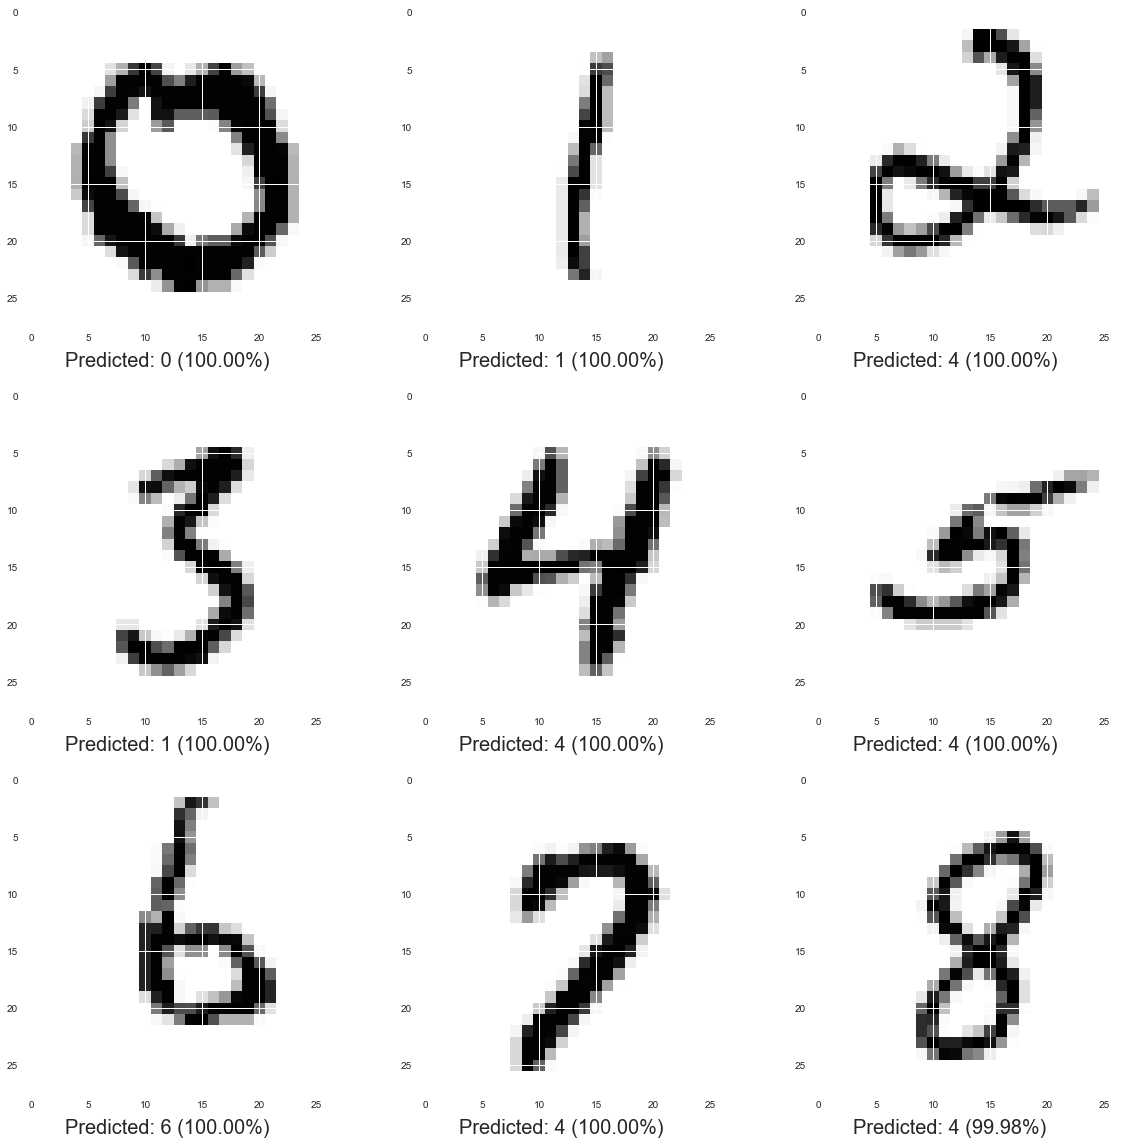

In [17]:
dw.multi_plot(testing, test_loader, adversarial=False)

In [18]:
df = dw.dataframer(testing)
#df.to_pickle(r"../data/neuroevolution4")

In [19]:
opts = df.columns.tolist()[:-1] #last column contains dicts which causes bokeh to fail
gen_opts = ['all'] + df['Generation'].unique().tolist() 
y1_opts = opts[2:] + opts[:2]
y2_opts = opts[1:] + opts[:1]
interactive_plot = interactive(dw.int_plot, df=fixed(df), x=opts, y=y1_opts, x2=opts, y2=y2_opts, gen=gen_opts)

In [20]:
interactive_plot #bokeh does not show on Github due to JS restrictions

interactive(children=(Dropdown(description='x', options=('Generation', 'Clean', 'Adversarial', 'No_layers', 'L…

# Debugging

In [21]:
model = dw.rebuild_from_save(0,generation=38,position=4,run=1)

{'lr': 0.05184926115229526, 'optimizer': 'adadelta', 'layers': [{'nb_units': 1331, 'activation': 'linear', 'dropout_rate': 0.5920481211841264}], 'weight_decay': 0.0002442487687208515, 'nb_layers': 1}


In [22]:
dw.test(model, test_loader)

(0.0017532868616991024, 8491)

In [23]:
dw.test(model, test_loader, adversarial=True, adv_func=atk_func.fgsm, eps=0.1)

(0.002161438935789422, 2741)

[[4.39765713e-02 2.71795907e-04 4.45183423e-04 9.97763242e-03
  2.38134395e-03 8.68768007e-01 5.28081259e-03 5.37726515e-04
  6.67303253e-02 1.63060161e-03]]
[[3.83965610e-03 2.35100350e-04 6.34412613e-03 9.32219298e-03
  1.02077518e-03 1.81234828e-02 1.84675197e-03 3.37370280e-04
  9.52996249e-01 5.93429550e-03]]
[[6.53177460e-03 4.51966469e-04 2.27460316e-02 5.83682072e-01
  7.87226784e-04 3.83624861e-03 1.42185383e-04 1.21803487e-02
  3.36023653e-01 3.36184931e-02]]
[[3.32366429e-01 4.14243690e-04 1.12413756e-03 3.08682341e-03
  1.40586087e-03 2.92446401e-02 1.28781339e-03 5.24941740e-01
  6.70013853e-02 3.91269273e-02]]
[[1.00810691e-01 6.32364118e-04 2.29096257e-02 9.38402616e-02
  2.04147051e-03 1.15231511e-02 3.70727441e-03 7.49010194e-03
  6.42791265e-01 1.14253794e-01]]
[[1.63557238e-03 2.70505354e-03 2.97831298e-03 4.07258264e-01
  1.67552852e-02 2.58245570e-04 1.10538573e-03 3.72962748e-02
  1.05358028e-01 4.24649578e-01]]
[[1.15999736e-01 1.05203743e-04 2.83970705e-01 3.139

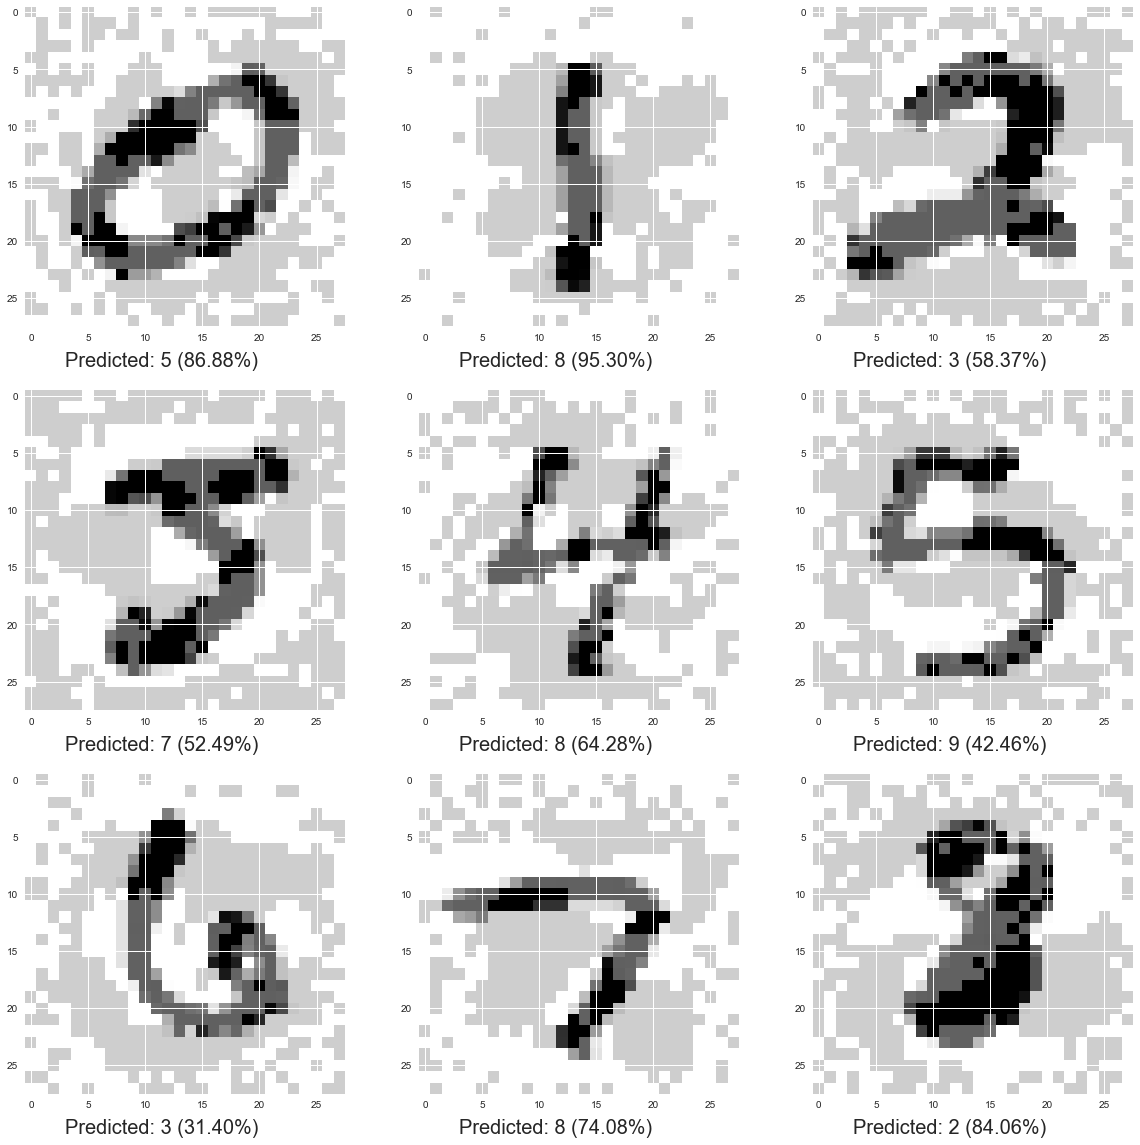

In [24]:
dw.multi_plot(testing, test_loader, adv_func=atk_func.fgsm, adversarial=True, eps=0.3, model=model)

In [25]:
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

In [26]:
batch = next(iter(test_loader))
img = batch[0][0].data
label = batch[1][0]

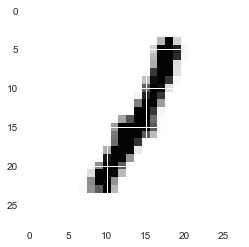

In [27]:
plt.imshow(img.numpy().reshape(28,28), cmap='Greys')

In [28]:
label

tensor(1)

clean softmax =  tensor([[ 0.0009,  0.5799,  0.1305,  0.0264,  0.0111,  0.0020,  0.0172,
          0.0056,  0.2167,  0.0096]], dtype=torch.float64, device='cuda:0') 1 0.579921307002547 

clean logits =  tensor([[-2.9762,  3.4410,  1.9498,  0.3523, -0.5114, -2.2270, -0.0779,
         -1.2068,  2.4566, -0.6592]], dtype=torch.float64, device='cuda:0') 1 3.4410290809944546 

logits = tensor([[  4.9549, -14.1665,   7.7362,   0.8394,  -4.7416,   1.8016,
          -3.2658,  -7.6948,   7.4278,  -4.6989]], dtype=torch.float64, device='cuda:0') 2 7.736175352271118 

softmax = tensor([[ 3.4418e-02,  1.7078e-10,  5.5548e-01,  5.6160e-04,  2.1165e-06,
          1.4699e-03,  9.2594e-06,  1.1042e-07,  4.0806e-01,  2.2089e-06]], dtype=torch.float64, device='cuda:0') 2 0.5554759095017914 



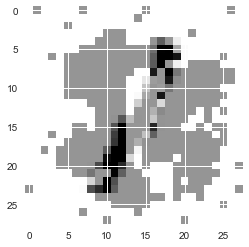

In [29]:
grads = {}

def save_grad(name):  #closure for use as a hook in fgsm attack - otherwise gradients can't be obtained for images. 
    def hook(grad):
        grads[name] = grad
    return hook

x = Variable(img, requires_grad=True).cuda().double()
x.register_hook(save_grad('grad'))
h_adv = model.logits_forward(x)
h = model(x)
h_logs = model.logits_forward(x)
print('clean softmax = ', h.data, h.argmax().item(), h.max().item(), '\n')
print('clean logits = ', h_logs, h_logs.argmax().item(), h_logs.max().item(), '\n')
h_adv.shape
h_adv
h_adv.max()
criterion = torch.nn.CrossEntropyLoss()
cost = criterion(h_adv, label.cuda().view(1))
cost.backward()
imge = (img.double() + grads['grad'].cpu().sign().double() *0.5)
logits = model.logits_forward(imge.cuda())
print('logits =', logits.data, logits.argmax().item(), logits.max().item(), '\n')
soft = model(imge.cuda())
print('softmax =', soft.data, soft.argmax().item(), soft.max().item(), '\n')
imge = imge.cpu().numpy().reshape(28,28)
plt.imshow(imge ,cmap='Greys')